## 市场相对轮动图

*对市场内股票数据进行统计，观察样本变化。*

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pymongo
import pandas as pd
from datetime import datetime

startTime = datetime(2022,9,11)
endTime = datetime(2023,1,19, 10)

In [4]:
symbolList = ['btc_usdt.spot:binance', 'eth_usdt.spot:binance', 'bnb_usdt.spot:binance', 'ltc_usdt.spot:binance','bch_usdt.spot:binance',
             'doge_usdt.spot:binance', 'matic_usdt.spot:binance', 'sol_usdt.spot:binance','link_usdt.spot:binance','uni_usdt.spot:binance',
              'gala_usdt.spot:binance', 'sand_usdt.spot:binance', 'axs_usdt.spot:binance'
             ]

client = pymongo.MongoClient('172.16.20.81', 27017)

In [5]:
def readDb(collection, start, end):
    return pd.DataFrame(
        list(collection.find({"datetime": {'$gt': start, '$lt': end}}))
    )

In [6]:

dbClient = client['Kline_1Min_Auto_Db_Plus']
columnsName = ['open', 'high', 'low', 'close', 'volume','datetime']

In [7]:
crytoDict = {
                'btc':readDb(dbClient[symbolList[0]], start=startTime , end=endTime)[columnsName],
                'eth':readDb(dbClient[symbolList[1]], start=startTime , end=endTime)[columnsName],
                'bnb':readDb(dbClient[symbolList[2]], start=startTime , end=endTime)[columnsName],
                'ltc':readDb(dbClient[symbolList[3]], start=startTime , end=endTime)[columnsName],
                'bch':readDb(dbClient[symbolList[4]], start=startTime , end=endTime)[columnsName],
                'doge':readDb(dbClient[symbolList[5]], start=startTime , end=endTime)[columnsName],
                'matic':readDb(dbClient[symbolList[6]], start=startTime , end=endTime)[columnsName],
                'sol':readDb(dbClient[symbolList[7]], start=startTime , end=endTime)[columnsName],
                'link':readDb(dbClient[symbolList[8]], start=startTime , end=endTime)[columnsName],
                'uni':readDb(dbClient[symbolList[9]], start=startTime , end=endTime)[columnsName],
                'gala':readDb(dbClient[symbolList[10]], start=startTime , end=endTime)[columnsName],
                'sand':readDb(dbClient[symbolList[11]], start=startTime , end=endTime)[columnsName],
                'axs':readDb(dbClient[symbolList[12]], start=startTime , end=endTime)[columnsName],
            }

In [8]:
# crytoDict

In [9]:
def resampleDf(data, freq='D'):
#     df = data.drop('_id', axis=1)
    dataDf = df.set_index('datetime')
    dataDayDf = dataDf.resample(freq).agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
    dataResetDf = dataDayDf.reset_index()
    dataResetDf['date'] = list(map(lambda dt: str(dt.date()), dataResetDf['datetime']))
    return dataResetDf

In [10]:
def addSymbol(dataDf, symbolName):
    dataDf['symbol'] = symbolName
    return dataDf

In [11]:
def setIndex(dataDf):
    dataIndex = dataDf.set_index(['date', 'symbol'])
    return dataIndex

In [12]:
multiCryptoDict = {}
for key, df in crytoDict.items():
    hourDf = resampleDf(df)
    hourSymbolDf = addSymbol(hourDf, key)
    hourIndexDf = setIndex(hourSymbolDf)
    multiCryptoDict[key] = hourIndexDf

In [13]:
multiDf = pd.concat(list(multiCryptoDict.values())).sort_index()

In [14]:
multiDf

datetime         open         high          low  \
date       symbol                                                     
2022-09-11 axs    2022-09-11     14.43000     14.80000     14.20000   
           bch    2022-09-11    133.10000    133.80000    128.00000   
           bnb    2022-09-11    293.30000    298.60000    291.70000   
           btc    2022-09-11  21238.50000  21810.80000  21171.44000   
           doge   2022-09-11      0.06394      0.06557      0.06284   
...                      ...          ...          ...          ...   
2023-01-19 ltc    2023-01-19     84.95000     85.70000     82.11000   
           matic  2023-01-19      0.97590      0.98700      0.92500   
           sand   2023-01-19      0.70270      0.74230      0.66440   
           sol    2023-01-19     21.78000     22.53000     20.34000   
           uni    2023-01-19      6.29600      6.36300      6.00000   

                        close        volume  
date       symbol                            
2022-09-11 axs        14.5200  5.606104e+05  
           bch       130.7000  7.881359e+04  
           bnb       294.5000  2.568850e+05  
           btc     21643.1600  2.707467e+05  
           doge        0.0642  7.357631e+08  
...                       ...           ...  
2023-01-19 ltc        82.8700  5.089733e+05  
           matic       0.9390  5.923762e+07  
           sand        0.6770  3.271845e+07  
           sol        21.0200  6.377512e+06  
           uni         6.0630  1.608331e+06  

[1703 rows x 6 columns]

In [15]:
closePrice = multiDf['close'].unstack()

In [16]:
rsDf = pd.DataFrame({name: closePrice[name]/closePrice['btc']*100 for name in closePrice.columns})
rsDf['btc'] = closePrice['btc']

In [17]:
shortPeriodParam = 7
longPeriodParam = shortPeriodParam*4

In [18]:
normalizationRS = 100+ (rsDf.rolling(shortPeriodParam).mean() -rsDf.rolling(longPeriodParam).mean())/rsDf.rolling(longPeriodParam).std()

In [19]:
normalizationRS.btc.plot()

<AxesSubplot:xlabel='date'>

In [20]:
RS_Mom = normalizationRS.pct_change()
jdk_rs_mom = 100+(RS_Mom - RS_Mom.rolling(longPeriodParam).mean())/RS_Mom.rolling(longPeriodParam).std()

<AxesSubplot:xlabel='date'>

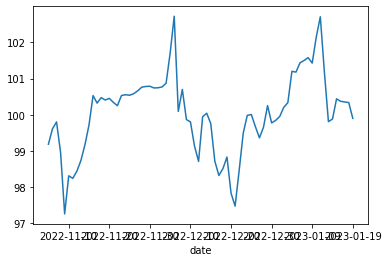

In [21]:
jdk_rs_mom.btc.plot()

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def setup_plot(fig, ax):
    ax.set_title("Relative Rotation Graph")
    ax.set_xlabel("RS-Ratio")
    ax.set_ylabel("RS-Momentum")
    plt.figtext(0.14, 0.14, "Lagging", color="red")
    plt.figtext(0.14, 0.84, "Improving", color="blue")
    plt.figtext(0.87, 0.84, "Leading", color="green", ha="right")
    plt.figtext(0.87, 0.14, "Weakening", color="gold", ha="right")
    windowZoom = 5
    lim = [100 - windowZoom, 100 + windowZoom]
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.axhline(y=100, color="gray", linewidth=0.5)
    ax.axvline(x=100, color="gray", linewidth=0.5)
    rect = patches.Rectangle((0, 0), 100, 100, facecolor="red", alpha=0.2)
    ax.add_patch(rect)
    rect = patches.Rectangle((0, 100), 100, 100, facecolor="blue", alpha=0.2)
    ax.add_patch(rect)
    rect = patches.Rectangle((100, 100), 100, 100, facecolor="green", alpha=0.2)
    ax.add_patch(rect)
    rect = patches.Rectangle((100, 0), 100, 100, facecolor="yellow", alpha=0.2)
    ax.add_patch(rect)
    plt.gcf().set_size_inches(10, 10)

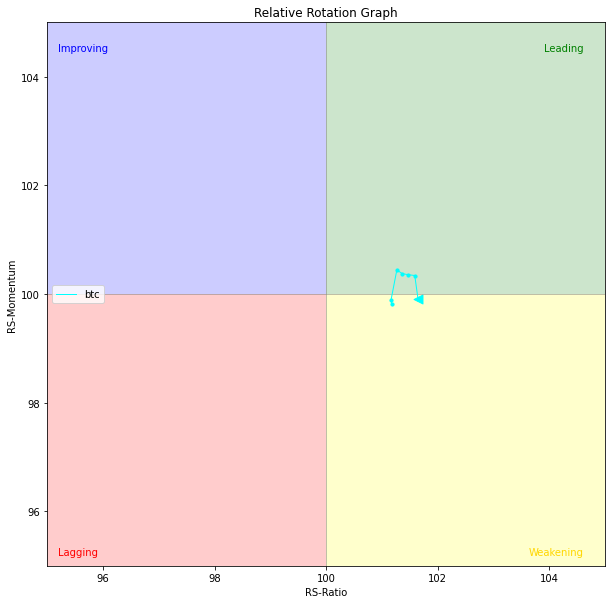

In [23]:
figBtc, ax = plt.subplots()
setup_plot(figBtc, ax)
ax.plot(
    normalizationRS.btc.iloc[-7:],
    jdk_rs_mom.btc.iloc[-7:],
    color='cyan',
    linewidth=1,
    label='btc'
)
ax.scatter(normalizationRS.btc.iloc[-7:], jdk_rs_mom.btc.iloc[-7:], c='cyan', marker='o', s=10)
ax.scatter(normalizationRS.btc.iloc[-1:], jdk_rs_mom.btc.iloc[-1:], c='cyan', marker='<', s=80)
ax.legend(loc='center left')
figBtc.savefig('btcRrg')

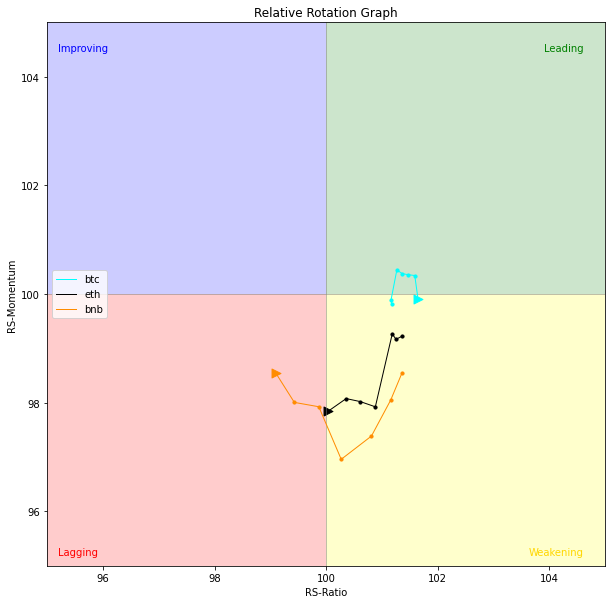

In [24]:
symbolColor = {'btc': 'cyan', 'eth': 'black', 'bnb': 'darkorange'}
figMainCoin, ax = plt.subplots()
setup_plot(figMainCoin, ax)
for symbol, color in symbolColor.items():
    ax.plot(
        normalizationRS[symbol].iloc[-7:],
        jdk_rs_mom[symbol].iloc[-7:],
        color=color,
        linewidth=1,
        label=symbol
    )
    ax.scatter(normalizationRS[symbol].iloc[-7:-1], jdk_rs_mom[symbol].iloc[-7:-1], c=color, marker='o', s=10)
    ax.scatter(normalizationRS[symbol].iloc[-1:], jdk_rs_mom[symbol].iloc[-1:], c=color, marker='>', s=80)
    ax.legend(loc='center left')
figMainCoin.savefig('mainCoin')

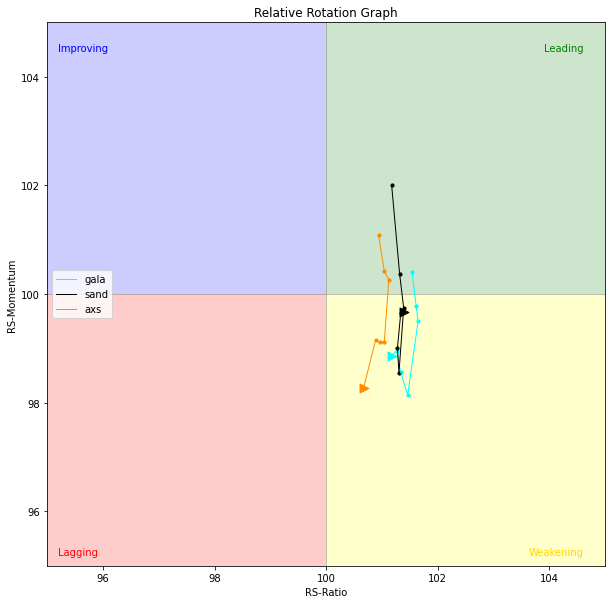

In [25]:
symbolColor = {'gala': 'cyan', 'sand': 'black', 'axs': 'darkorange'}
figGame, ax = plt.subplots()
setup_plot(figGame, ax)
for symbol, color in symbolColor.items():
    ax.plot(
        normalizationRS[symbol].iloc[-7:],
        jdk_rs_mom[symbol].iloc[-7:],
        color=color,
        linewidth=1,
        label=symbol
    )
    ax.scatter(normalizationRS[symbol].iloc[-7:-1], jdk_rs_mom[symbol].iloc[-7:-1], c=color, marker='o', s=10)
    ax.scatter(normalizationRS[symbol].iloc[-1:], jdk_rs_mom[symbol].iloc[-1:], c=color, marker='>', s=80)
    ax.legend(loc='center left')
figGame.savefig('gameCoin')

In [26]:
improvingDict = {}
leadingDict = {}
for s in crytoDict.keys():
    RS = pd.concat([normalizationRS[s].iloc[-1:], jdk_rs_mom[s].iloc[-1:]], axis=1, keys=['RS_Ratio', 'RS_Momentum'])
    for i, v in RS.iterrows():
        if v['RS_Momentum']>100 and v['RS_Ratio']>100:
            leadingDict[s] = i
        elif v['RS_Momentum']>100 and v['RS_Ratio']<100:
            improvingDict[s] = i

In [27]:
improvingDf = pd.Series(improvingDict).to_frame('Improving_Area')
leadingDf = pd.Series(leadingDict).to_frame('Leading_Area')

In [28]:
buyDf = pd.concat([leadingDf, improvingDf], axis=1)

In [29]:
buyDf.to_excel('buyDf.xlsx')

In [30]:
buyDf

,Leading_Area,Improving_Area
